In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
from tqdm import trange

In [ ]:

def drawModel1D(ax, thickness=None, values=None, model=None, depths=None,
                plot='plot',
                xlabel=r'Resistividad $(\Omega$m$)$', zlabel='Profundidad (m)',
                z0=0,
                **kwargs):
    """Draw 1d block model into axis ax.

    Draw 1d block model into axis ax defined by values and thickness vectors
    using plot function.
    For log y cases, z0 should be set > 0 so that the default becomes 1.

    Parameters
    ----------
    ax : mpl axes
        Matplotlib Axes object to plot into.

    values : iterable [float]
        [N] Values for each layer plus lower background.

    thickness : iterable [float]
        [N-1] thickness for each layer. Either thickness or depths must be set.

    depths : iterable [float]
        [N-1] Values for layer depths (positive z-coordinates).
        Either thickness or depths must be set.

    model : iterable [float]
        Shortcut to use default model definition.
        thks = model[0:nLay]
        values = model[nLay:]

    plot : string
        Matplotlib plotting function.
        'plot', 'semilogx', 'semilogy', 'loglog'

    xlabel : str
        Label for x axis.

    ylabel : str
        Label for y axis.

    z0 : float
        Starting depth in m

    **kwargs : dict()
        Forwarded to the plot routine

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> import pygimli as pg
    >>> # plt.style.use('ggplot')
    >>> thk = [1, 4, 4]
    >>> res = np.array([10., 5, 15, 50])
    >>> fig, ax = plt.subplots()
    >>> pg.viewer.mpl.drawModel1D(ax, values=res*5, depths=np.cumsum(thk),
    ...                          plot='semilogx', color='blue')
    >>> pg.viewer.mpl.drawModel1D(ax, values=res, thickness=thk, z0=1,
    ...                          plot='semilogx', color='red')
    >>> pg.wait()
    """
    if model is not None:
        nLayers = (len(model)-1)//2
        thickness = model[:nLayers]
        values = model[nLayers:]

    if thickness is None and depths is None:
        raise Exception("Either thickness or depths must be given.")

    nLayers = len(values)
    px = np.zeros(nLayers * 2)
    pz = np.zeros(nLayers * 2)

    if thickness is not None:
        z1 = np.cumsum(thickness) + z0
    else:
        z1 = depths

    for i in range(nLayers):
        px[2 * i] = values[i]
        px[2 * i + 1] = values[i]

        if i == nLayers - 1:
            pz[2 * i + 1] = z1[i - 1] * 1.2
        else:
            pz[2 * i + 1] = z1[i]
            pz[2 * i + 2] = z1[i]

    if plot == 'loglog' or plot == 'semilogy':
        if z0 == 0:
            pz[0] = z1[0] / 2.
        else:
            pz[0] = z0

    try:
        plot = getattr(ax, plot)
        plot(px, pz+z0, **kwargs)
    except BaseException as e:
        print(e)

    ax.set_ylabel(zlabel)
    ax.set_xlabel(xlabel)
    # assume positive depths pointing upward
    ax.set_ylim(pz[-1], pz[0])
    ax.grid(True)

In [ ]:
@tf.function
def forward(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant([4, 8, 15, 23], dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

In [ ]:
synres = tf.constant([35, 150, 250, 90, 50], dtype = tf.float64)
synthk = tf.constant([4, 8, 15, 23], dtype = tf.float64)

In [ ]:
synthetic_data = forward(synres)

synthetic_data_log = tf.cast(tf.math.log(synthetic_data) / tf.math.log(tf.constant(10.0, dtype=tf.float64)), dtype=tf.float64)

In [ ]:
print(synthetic_data)

tf.Tensor(
[ 36.29789669  36.9257922   37.8191454   39.06400692  40.75681587
  42.99397715  45.85650186  49.39420528  53.61588752  58.49004248
  63.95549525  69.93606108  76.35117155  83.11652406  90.13357594
  97.2714044  104.3472318  111.11251368 117.25053189 122.38949265
 126.13247415 128.10251737 127.99817447 125.65218371 121.0834288
 114.52984047 106.44855441  97.47240071  88.3216456   79.68607125], shape=(30,), dtype=float64)


In [ ]:
print(np.sum(np.logspace(0.0, 0.9, 15)))

51.463933821499204


In [ ]:
@tf.function
def forwarde(res):
    res = tf.cast(res, tf.float64)
    ab2 = tf.cast(np.logspace(0.4, 2.2, 30), dtype=tf.float64)
    lays = tf.shape(res)[0] - 1
    thk = tf.constant(np.logspace(0.0, 0.9, 15), dtype = tf.float64)
    thick = tf.cast(thk, dtype=tf.float64)

    LOG = tf.math.log(tf.cast(10.0, dtype=tf.float64))
    COUNTER = 1 + (2 * 13 - 2)
    UP = tf.exp(0.5 * LOG / 4.438)

    up = ab2 * tf.exp(-10.0 * LOG / 4.438)
    ti = tf.TensorArray(dtype=tf.float64, size=COUNTER)

    for ii in range(COUNTER):
        ti1 = tf.fill(tf.shape(up), res[lays])

        lay = lays
        while lay > 0:
            lay -= 1
            tan_h = tf.tanh(thick[lay] / up)
            ti1 = (ti1 + res[lay] * tan_h) / (1 + ti1 * tan_h / res[lay])

        ti = ti.write(ii, ti1)
        up *= UP

    ti = ti.stack()

    weights = tf.constant([105, 0, -262, 0, 416, 0, -746, 0, 1605, 0, -4390, 0, 13396, 0, -27841,
                           0, 16448, 0, 8183, 0, 2525, 0, 336, 0, 225], dtype=tf.float64)
    weighted_ti = tf.tensordot(weights, ti, axes=1)
    res_a = weighted_ti / 1e4

    return res_a

In [ ]:
#RED PAUL GOYES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

def build_model(input_dim, output_dim, nc, ly):
    #regout = OuterLayer()
    # Define the input layer



    input_layer = Input(shape=(input_dim,))
    #previous_layer = input_layer
    previous_layer = Dense(nc, activation='relu')(input_layer)
    # Initialize a list to hold the hidden layers tf.keras.layers.LeakyReLU()
    hidden_layers = []

    # Create the hidden layers
    for _ in range(ly):
        hidden_layer = Dense(nc, activation='relu',kernel_regularizer='l1')(previous_layer)
        hidden_layers.append(hidden_layer)
        previous_layer = keras.layers.add([previous_layer, hidden_layer])  # Sum with the previous layer

    # Add the output layer
    output_layer = Dense(output_dim, activation='sigmoid')(previous_layer)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage:
input_dim = 30  # Adjust based on your input size
output_dim = 16  # Adjust based on your output size
nc = 128*4  # Number of channels per hidden layer
ly = 1  # Number of hidden layers

model = build_model(input_dim, output_dim, nc, ly)

In [ ]:
#num_layers = 25  # Número de espesores
X_train = tf.reshape(synthetic_data_log, (1, len(synthetic_data_log)))
print(X_train)

tf.Tensor(
[[1.55988146 1.56732982 1.57771171 1.59177679 1.61020025 1.63340762
  1.66140092 1.693676   1.7292935  1.76708194 1.80587787 1.84470117
  1.88281571 1.91968737 1.9548866  1.98798519 2.01848093 2.04576297
  2.06911482 2.08774413 2.10082691 2.10755766 2.10720378 2.09917004
  2.08308471 2.05891866 2.02713977 1.98888166 1.94606715 1.90138242]], shape=(1, 30), dtype=float64)


In [ ]:
optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4)
@tf.function
def train(model, d_obs):
    with tf.GradientTape() as tape:
        model_pred = tf.squeeze(model(d_obs, training=True))

        scaled_model_pred = 10 ** (3 * model_pred)
        d_pred = forwarde(scaled_model_pred)

        log_d_pred = tf.math.log(d_pred) / tf.math.log(tf.constant(10.0, dtype=tf.float64))

        # Calcular la segunda parte de la pérdida (diff / logspace_tensor)
        diff = tf.math.subtract(model_pred[1:], model_pred[:-1])
        diff = tf.cast(diff, dtype=tf.float64)
        logspace_tensor = tf.constant(np.logspace(0.0, 0.9, 15), dtype=tf.float64)

        loss_diff = tf.nn.l2_loss(diff / logspace_tensor)

        # Pérdida total
        loss = (0.5) * tf.norm(d_obs - log_d_pred, ord=2) + loss_diff

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss

In [ ]:
# Entrenamiento
loss_i = []
niter = trange(500)
model = build_model(input_dim, output_dim, nc, ly)
for i in niter:
    loss = train(model, X_train)
    loss_i.append(loss.numpy())
    niter.set_postfix(LOSS=loss.numpy())

100%|██████████| 500/500 [00:47<00:00, 10.54it/s, LOSS=0.00945]


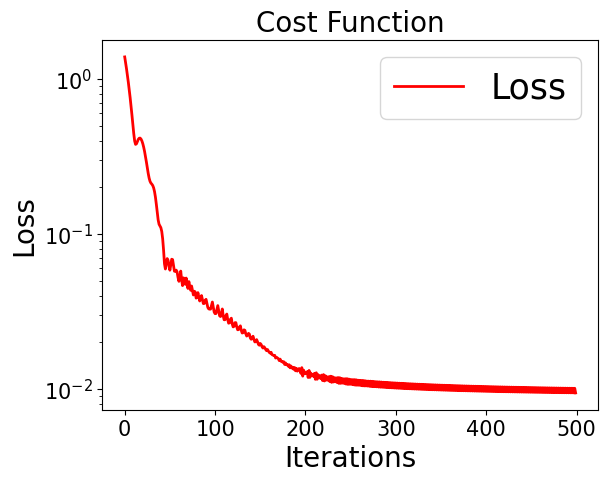

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# Crear el gráfico
plt.plot(loss_i, label='Loss', color='red', linewidth=2)  # Grosor de la línea aumentado
plt.title('Cost Function', fontsize=20)  # Título más corto con fuente más grande
plt.xlabel('Iterations', fontsize=20)  # Tamaño de fuente mayor para las etiquetas
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=25)  # Aumentar tamaño de fuente de la leyenda
plt.grid(False)

# Aumentar tamaño de los ticks en los ejes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')

# Guardar el gráfico como PNG de alta calidad
plt.savefig('loss_plot.svg', format='svg', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# Descargar el archivo generado (descomentar si estás usando Colab)
#files.download('loss_plot.svg')


In [ ]:
# Evaluar y graficar las predicciones
ab2 = tf.cast(np.logspace(0.4, 2.5, 30), dtype=tf.float64)

In [ ]:
print(ab2)

tf.Tensor(
[  2.51188643   2.96765761   3.50612654   4.14229838   4.89390092
   5.78187856   6.83097599   8.07042771   9.53477271  11.26481692
  13.30877035  15.72359048  18.57656952  21.94720955  25.92943797
  30.63422491  36.19267556  42.75968358  50.51824745  59.68456995
  70.51408293  83.30856527  98.42455236 116.28327142 137.38237959
 162.30983176 191.76026478 226.5543544  267.66168455 316.22776602], shape=(30,), dtype=float64)


In [ ]:
print(ab2)
print(synthetic_data)

tf.Tensor(
[  2.51188643   2.96765761   3.50612654   4.14229838   4.89390092
   5.78187856   6.83097599   8.07042771   9.53477271  11.26481692
  13.30877035  15.72359048  18.57656952  21.94720955  25.92943797
  30.63422491  36.19267556  42.75968358  50.51824745  59.68456995
  70.51408293  83.30856527  98.42455236 116.28327142 137.38237959
 162.30983176 191.76026478 226.5543544  267.66168455 316.22776602], shape=(30,), dtype=float64)
tf.Tensor(
[ 36.29789669  36.9257922   37.8191454   39.06400692  40.75681587
  42.99397715  45.85650186  49.39420528  53.61588752  58.49004248
  63.95549525  69.93606108  76.35117155  83.11652406  90.13357594
  97.2714044  104.3472318  111.11251368 117.25053189 122.38949265
 126.13247415 128.10251737 127.99817447 125.65218371 121.0834288
 114.52984047 106.44855441  97.47240071  88.3216456   79.68607125], shape=(30,), dtype=float64)


In [ ]:
model_pred = tf.squeeze(model(X_train,training=False))
scaled_model_pred = 10 ** (3 * model_pred)
d_pred = forwarde(scaled_model_pred)

print(model_pred.shape[0])

16


In [ ]:
print(f'Resistividad aparente pred: {d_pred}')
print(f'Resistividad aparente medida: {synthetic_data}')

Resistividad aparente pred: [ 36.52602432  37.12957236  38.04773073  39.35652084  41.1285991
  43.4287977   46.31009375  49.81013509  53.94852019  58.72492997
  64.11786699  70.0833419   76.55264409  83.42854373  90.57988583
  97.83535498 104.97795483 111.74227516 117.81688364 122.85428897
 126.49093871 128.37934997 128.23296242 125.88081497 121.32357919
 114.77621996 106.67875041  97.6593722   88.44649618  79.74555672]
Resistividad aparente medida: [ 36.29789669  36.9257922   37.8191454   39.06400692  40.75681587
  42.99397715  45.85650186  49.39420528  53.61588752  58.49004248
  63.95549525  69.93606108  76.35117155  83.11652406  90.13357594
  97.2714044  104.3472318  111.11251368 117.25053189 122.38949265
 126.13247415 128.10251737 127.99817447 125.65218371 121.0834288
 114.52984047 106.44855441  97.47240071  88.3216456   79.68607125]


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

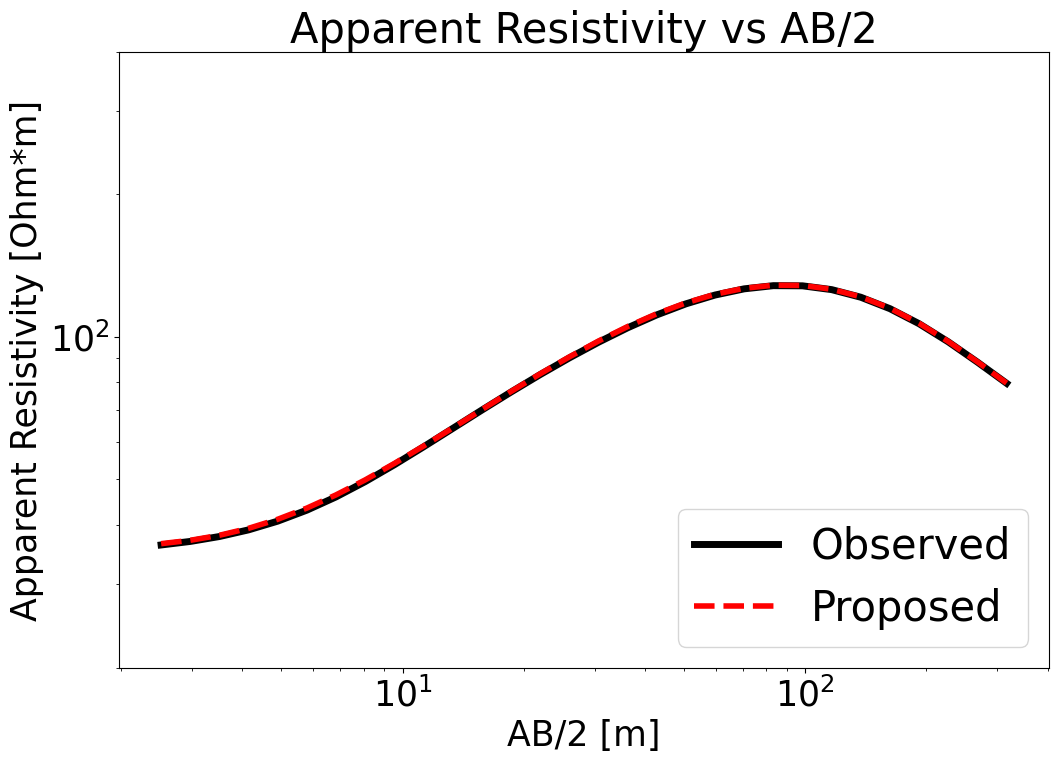

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# Crear el gráfico principal
fig, ax_main = plt.subplots(figsize=(12, 8))

# Datos observados
ax_main.plot(ab2, synthetic_data, linestyle='-', label='Observed', color='black', linewidth=5)

# Curva ajustada PINNs
ax_main.plot(ab2, d_pred, linestyle='dashed', label='Proposed', color='red', linewidth=4)

# Configuración de ejes y títulos
ax_main.set_ylim(20, 400)
ax_main.set_yscale('log')
ax_main.set_xscale('log')
ax_main.set_xlabel('AB/2 [m]', fontsize=25)
ax_main.set_ylabel('Apparent Resistivity [Ohm*m]', fontsize=25)
ax_main.set_title('Apparent Resistivity vs AB/2', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=25)
ax_main.legend(fontsize=30, loc='lower right')

# Desactivar la cuadrícula
ax_main.grid(False)

# Establecer el fondo del gráfico
fig.patch.set_facecolor('white')

# Guardar como SVG
file_name = 'responseEXP1.svg'
plt.savefig(file_name, format='svg', bbox_inches='tight')

# Descargar el archivo en Colab
#files.download(file_name)

# Mostrar el gráfico
plt.show()


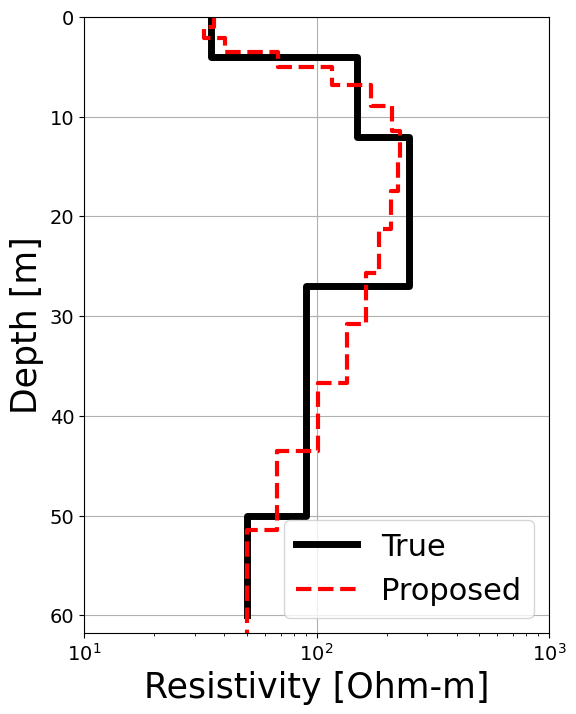

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# Crear el gráfico
fig, ax = plt.subplots(figsize=(6, 8))

# Modelo Teórico
drawModel1D(ax, thickness=synthk, values=synres, plot='semilogx', linewidth=5.0, color='black', label='True')

# Modelo invertido PINNs
drawModel1D(ax, thickness=np.logspace(0.0, 0.9, 15), values=scaled_model_pred, plot='semilogx',
            color='red', linestyle='dashed', label='Proposed', linewidth=3.0)

# Configuración de los ejes
ax.set_xlabel('Resistivity [Ohm-m]', fontsize=25)
ax.set_ylabel('Depth [m]', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=22, loc='lower right')
plt.xlim([10, 10**3])

# Establecer el fondo del gráfico
fig.patch.set_facecolor('white')

# Guardar como SVG
file_name = 'EXP1.svg'
plt.savefig(file_name, format='svg', bbox_inches='tight')

# Descargar el archivo
#files.download(file_name)

# Mostrar el gráfico
plt.show()

In [ ]:
import numpy as np

# ---------- Primer modelo: propuesto ----------
y_true = synthetic_data
y_pred = d_pred

diff = np.subtract(y_true, y_pred)
square = np.square(diff)
MSE = square.mean()
RMSPE = np.sqrt(MSE)
RMSPE_percent = (RMSPE / np.mean(np.abs(y_true))) * 100

print("RMSPE (%) (propuesto):", RMSPE_percent)

RMSPE (%) (propuesto): 0.4213003151177084
